In [10]:
!mkdir checkpoint
CUDA_LAUNCH_BLOCKING=1
import os, time, random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from matplotlib import pyplot as plt
import itertools
#remember to upload data into your colab workspace
import os, time, random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from matplotlib import pyplot as plt
import itertools
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pickle

# GPU support
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)


def impute_missing_values(X):
    """
    For each feature column, impute missing values  (np.nan) with the 
    population mean for that feature.
    
    Args:
        X: np.array, shape (N, L, d). X could contain missing values
    Returns:
        X: np.array, shape (N, L, d). X does not contain any missing values
    """
    N, L, d = X.shape
    X = X.reshape(N*L, d)
    col_means = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_means, inds[1])
    return X.reshape(N, L, d)

def fill_missing_values(X):
    N, L, d = X.shape
    X = X.reshape(N*L, d)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(0, inds[1])
    return X.reshape(N, L, d)
def standardize_features(X):
    """
    For each feature column, normalize all values to range [0, 1].
    Args:
        X: np.array, shape (N, d).
    Returns:
        X: np.array, shape (N, d). Values are normalized per column.
    """
    scaler = StandardScaler()
    N, L, d = X.shape  
    X = X.reshape(N*L, d) 
    X = scaler.fit_transform(X)
    return X.reshape(N, L, d)

#with open("features_labels_12000.p", 'rb') as f:
#      features, df_labels = pickle.load(f)
#      X = np.array([df_i.values for df_i in features])[0:10000,:,:]
#      y = df_labels['In-hospital_death'].values.copy()[0:10000]
#      y[y == -1] = 0

#np.save("X.npy",X)


import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np



mkdir: cannot create directory ‘checkpoint’: File exists
using device: cuda


#Model 1

In [ ]:
import torch

result=[]
for padding in [1]:#range(1,5):
      print("-------------")
      print("kernel_size",2*padding+1)
      print("-------------")
  
      class SimpleDataset(Dataset):
          def __init__(self, X, y):
              self.X, self.y = X, y
          def __getitem__(self, idx):
              return torch.from_numpy(self.X[idx]).float(), torch.tensor([self.y[idx]]).float()
          def __len__(self):
              return len(self.X)

      def get_train_val_test(batch_size=64):

          X=np.zeros((10000,48,147))
          z=np.load("data_nmiss_CF.npz")
          X[:,:,0:35]=z["X"]
          X[:,:,35:70]=np.load("X.npy")[:,:,35:70]
          X[:,:,70:105]=fill_missing_values(np.load("data_dist_backw.npz")["X"])
          X[:,:,105:140]=np.load("data_dist_backw.npz")["X"]#("data_times_backw_.npz")["X"]
          X[:,0,140:145]=np.load("imputed_invariant.npy")
          for i in range(4,48):
            X[:,i,140:145]=X[:,0,140:145]
          X[:,:,145:147]=np.ones((10000,48,2))
          print(np.shape(X))
          y=z["y"]
          
          #np.save("X.npy",X)
          #np.save("y.npy",y)
          X=impute_missing_values(X)
          X=standardize_features(X)
          X = X.transpose((0,2,1))
          #print(X.shape, y.shape)

          #print('Creating splits')
          Xtr, X__, ytr, y__ = train_test_split(X,   y,   train_size=0.8, stratify=y,   random_state=13)
          Xva, Xte, yva, yte = train_test_split(X__, y__, test_size=0.5, stratify=y__, random_state=13)

          tr = SimpleDataset(Xtr, ytr)
          va = SimpleDataset(Xva, yva)
          te = SimpleDataset(Xte, yte)

          tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True)
          va_loader = DataLoader(va, batch_size=batch_size)
          te_loader = DataLoader(te, batch_size=batch_size)

          #print('Feature shape, Label shape, Class balance:')
          #print('\t', tr_loader.dataset.X.shape, tr_loader.dataset.y.shape, tr_loader.dataset.y.mean())
          #print('\t', va_loader.dataset.X.shape, va_loader.dataset.y.shape, va_loader.dataset.y.mean())
          #print('\t', te_loader.dataset.X.shape, te_loader.dataset.y.shape, te_loader.dataset.y.mean())
          return tr_loader, va_loader, te_loader

      tr_loader, va_loader, te_loader = get_train_val_test(batch_size=64)

      ###################################################################

      class CNN(nn.Module):
          def __init__(self, in_channels, n_filters, output_size, sequence_len,padding):
              super().__init__()
              self.n_filters = n_filters
              self.win_channels=5
              self.l1    = nn.Linear(5, in_channels*sequence_len)
              #self.cl1 = nn.Conv1d(in_channels, n_filters, 2*padding+1, padding=padding)
              self.conv1 = nn.Conv1d(in_channels, n_filters, 2*padding+1, padding=padding)  #each filter considers one input channels (700)
              self.pool1 = nn.AvgPool1d(2)
              self.cl1 = nn.Conv1d(in_channels, n_filters, 2*padding+1, padding=padding)  #each filter considers one input channels (700)
              self.pll1 = nn.AvgPool1d(2)
              
              self.conv2 = nn.Conv1d(n_filters*2, n_filters, 2*padding+1, padding=padding)
              self.pool2 = nn.AvgPool1d(2)
              self.conv3 = nn.Conv1d(n_filters, n_filters, 2*padding+1, padding=padding)
              self.pool3 = nn.AvgPool1d(2)
              self.fc = nn.Linear(int(sequence_len/2/2/2)*n_filters, output_size )

          def forward(self, xx):
              xm =xx[:,35:70,:]
              #xm=torch.cat((xm,xx[:,145:147,:]),dim=1)
              xd=xx[:,70:105,:]
              #xc=xx[:,105:140,:]
              x = xx[:,0:35,:]
              xdt=torch.exp(-xd*xm)
              N, C, L = x.shape  # number of patients, channels/features, time
              
              t=self.l1(xx[:,140:145,0])
              t=t.view((N,C,L))
              #cl=self.cl1(t)
              
              z=self.conv1(x)
              
              w = self.conv1.weight
              #print(w.shape)
              wm = torch.abs(w) / torch.sum(torch.abs(w), dim=(1,2), keepdim=True)
              #t=wm.cpu().data.numpy()
              #temp=torch.from_numpy(np.random.binomial(1,t,np.shape(t))).type(torch.cuda.FloatTensor)
              # Apply the weights to the mask xm
              zm = F.conv1d(xm, wm, padding=padding)
              zd = F.conv1d(xdt, wm, padding=padding)
              
              #add probability 
              
              # Apply the first set of conv-elu-pool
              z = self.pool1(F.elu(z*zd))
              
              #z = self.pool1(zm*F.elu(z))
              temp=self.pll1(F.elu(self.cl1(t)))
              
              # Apply the second set of conv-elu-pool
              z = self.pool2(F.elu(self.conv2(torch.cat((temp,z),dim=1))))
              z = self.pool3(F.elu(self.conv3(z)))

              # Flatten the output from the convolutional/pooling layers
              z = z.view(N, -1)

              # Pass through the output layer and apply sigmoid activation
              z = torch.sigmoid(self.fc(z))

              return z
      ######################################################################

      def _train_epoch(data_loader, model, criterion, optimizer):
          """
          Train the `model` for one epoch of data from `data_loader`
          Use `optimizer` to optimize the specified `criterion`
          """
          model.train()
          for i, (X, y) in enumerate(data_loader):
              X, y = X.to(device), y.to(device)

              # clear parameter gradients
              optimizer.zero_grad()

              # forward + backward + optimize
              output = model(X)
              loss = criterion(output, y)
              loss.backward()
              optimizer.step()

      def _evaluate_epoch(tr_loader, va_loader, model, criterion):
          model.eval()
          with torch.no_grad():
              # Evaluate on train
              y_true, y_score = [], []
              running_loss = []
              for X, y in tr_loader:
                  X, y = X.to(device), y.to(device)
                  output = model(X)
                  y_true.append(y.cpu().numpy())
                  y_score.append(output.cpu().numpy())
                  running_loss.append(criterion(output, y).item())

              y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
              train_loss = np.mean(running_loss)
              train_score = metrics.roc_auc_score(y_true, y_score)
              #print('tr loss', train_loss, 'tr AUROC', train_score)

              # Evaluate on validation
              y_true, y_score = [], []
              running_loss = []
              for X, y in va_loader:
                  X, y = X.to(device), y.to(device)
                  with torch.no_grad():
                      output = model(X)
                      y_true.append(y.cpu().numpy())
                      y_score.append(output.cpu().numpy())
                      running_loss.append(criterion(output, y).item())

              y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
              val_loss = np.mean(running_loss)
              val_score = metrics.roc_auc_score(y_true, y_score)
              #print('va loss', val_loss, 'va AUROC', val_score)
          return train_loss, val_loss, train_score, val_score

      def save_checkpoint(model, epoch, checkpoint_dir):
          state = {
              'epoch': epoch,
              'state_dict': model.state_dict(),
          }

          filename = os.path.join(checkpoint_dir, 'epoch={}.checkpoint.pth.tar'.format(epoch))
          torch.save(state, filename)

      tr_loader, va_loader, te_loader = get_train_val_test(batch_size=64)

      torch.random.manual_seed(0)
      np.random.seed(0)
      random.seed(0)

      n_epochs = 20
      learning_rate = 1e-3

      for n_filters in range(20,30):
        #(self, in_channels, n_filters, output_size, sequence_len,padding)
        torch.random.manual_seed(0)
        np.random.seed(0)
        random.seed(0)
        model = CNN(35, n_filters, 1, 48,padding)

        model = model.to(device)
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        outputs = []

        #print('Epoch', 0)
        out = _evaluate_epoch(tr_loader, va_loader, model, criterion)
        outputs.append(out)

        for epoch in range(0, n_epochs):
            #print('Epoch', epoch+1)
            # Train model
            _train_epoch(tr_loader, model, criterion, optimizer)

            # Evaluate model
            out = _evaluate_epoch(tr_loader, va_loader, model, criterion)
            outputs.append(out)

            # Save model parameters
            #save_checkpoint(model, epoch+1, 'checkpoint/')

        train_losses, val_losses, train_scores, val_scores = zip(*outputs)
        print("n_filters:",n_filters," with maximum AUROC", max(val_scores) )
        
        if False:
          result.append(max(val_scores))

          fig, ax = plt.subplots(figsize=(5,5))
          plt.plot(range(n_epochs + 1), train_scores, '--o', label='Train')
          plt.plot(range(n_epochs + 1), val_scores, '--o', label='Validation')
          plt.title("CNN with mean imputation")
          plt.xlabel('epoch')
          plt.ylabel('AUROC')
          plt.legend()
          plt.savefig('auroc.png', dpi=300)

          fig, ax = plt.subplots(figsize=(5,5))
          plt.plot(range(n_epochs + 1), train_losses, '--o', label='Train')
          plt.plot(range(n_epochs + 1), val_losses, '--o', label='Validation')
          plt.title("CNN with mean imputation")
          plt.xlabel('epoch')
          plt.ylabel('Loss (binary cross entropy)')
          plt.legend()
          plt.savefig('loss.png', dpi=300)
    
        



-------------
kernel_size 3
-------------


FileNotFoundError: ignored

-------------
kernel_size 3
-------------
(10000, 48, 147)
(10000, 48, 147)
n_filters: 23  with maximum AUROC 0.8516780768822776


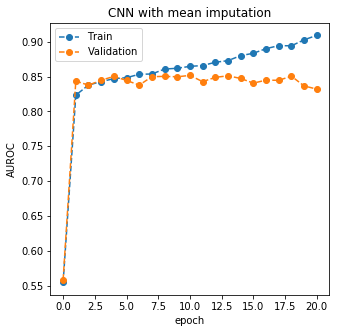

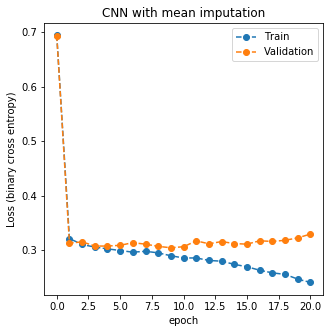

In [12]:
      import torch

      result=[]
#for padding in [1]:#range(1,5):
      padding=1
      print("-------------")
      print("kernel_size",2*padding+1)
      print("-------------")
  
      class SimpleDataset(Dataset):
          def __init__(self, X, y):
              self.X, self.y = X, y
          def __getitem__(self, idx):
              return torch.from_numpy(self.X[idx]).float(), torch.tensor([self.y[idx]]).float()
          def __len__(self):
              return len(self.X)

      def get_train_val_test(batch_size=64):

          X=np.zeros((10000,48,147))
          z=np.load("data_nmiss_CF.npz")
          X[:,:,0:35]=z["X"]
          X[:,:,35:70]=np.load("X.npy")[:,:,35:70]
          X[:,:,70:105]=fill_missing_values(np.load("data_dist_backw.npz")["X"])
          X[:,:,105:140]=np.load("data_dist_backw.npz")["X"]#("data_times_backw_.npz")["X"]
          X[:,0,140:145]=np.load("imputed_invariant.npy")
          for i in range(4,48):
            X[:,i,140:145]=X[:,0,140:145]
          X[:,:,145:147]=np.ones((10000,48,2))
          print(np.shape(X))
          y=z["y"]
          
          #np.save("X.npy",X)
          #np.save("y.npy",y)
          X=impute_missing_values(X)
          X=standardize_features(X)
          X = X.transpose((0,2,1))
          #print(X.shape, y.shape)

          #print('Creating splits')
          Xtr, X__, ytr, y__ = train_test_split(X,   y,   train_size=0.8, stratify=y,   random_state=13)
          Xva, Xte, yva, yte = train_test_split(X__, y__, test_size=0.5, stratify=y__, random_state=13)

          tr = SimpleDataset(Xtr, ytr)
          va = SimpleDataset(Xva, yva)
          te = SimpleDataset(Xte, yte)

          tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True)
          va_loader = DataLoader(va, batch_size=batch_size)
          te_loader = DataLoader(te, batch_size=batch_size)

          #print('Feature shape, Label shape, Class balance:')
          #print('\t', tr_loader.dataset.X.shape, tr_loader.dataset.y.shape, tr_loader.dataset.y.mean())
          #print('\t', va_loader.dataset.X.shape, va_loader.dataset.y.shape, va_loader.dataset.y.mean())
          #print('\t', te_loader.dataset.X.shape, te_loader.dataset.y.shape, te_loader.dataset.y.mean())
          return tr_loader, va_loader, te_loader

      tr_loader, va_loader, te_loader = get_train_val_test(batch_size=64)

      ###################################################################

      class CNN(nn.Module):
          def __init__(self, in_channels, n_filters, output_size, sequence_len,padding):
              super().__init__()
              self.n_filters = n_filters
              self.win_channels=5
              self.l1    = nn.Linear(5, in_channels*sequence_len)
              #self.cl1 = nn.Conv1d(in_channels, n_filters, 2*padding+1, padding=padding)
              self.conv1 = nn.Conv1d(in_channels, n_filters, 2*padding+1, padding=padding)  #each filter considers one input channels (700)
              self.pool1 = nn.AvgPool1d(2)
              self.cl1 = nn.Conv1d(in_channels, n_filters, 2*padding+1, padding=padding)  #each filter considers one input channels (700)
              self.pll1 = nn.AvgPool1d(2)
              
              self.conv2 = nn.Conv1d(n_filters*2, n_filters, 2*padding+1, padding=padding)
              self.pool2 = nn.AvgPool1d(2)
              self.conv3 = nn.Conv1d(n_filters, n_filters, 2*padding+1, padding=padding)
              self.pool3 = nn.AvgPool1d(2)
              self.fc = nn.Linear(int(sequence_len/2/2/2)*n_filters, output_size )

          def forward(self, xx):
              xm =xx[:,35:70,:]
              #xm=torch.cat((xm,xx[:,145:147,:]),dim=1)
              xd=xx[:,70:105,:]
              #xc=xx[:,105:140,:]
              x = xx[:,0:35,:]
              xdt=torch.exp(-xd*xm*0.5)
              N, C, L = x.shape  # number of patients, channels/features, time
              
              t=self.l1(xx[:,140:145,0])
              t=t.view((N,C,L))
              #cl=self.cl1(t)
              
              z=self.conv1(x)
              
              w = self.conv1.weight
              #print(w.shape)
              wm = torch.abs(w) / torch.sum(torch.abs(w), dim=(1,2), keepdim=True)
              #t=wm.cpu().data.numpy()
              #temp=torch.from_numpy(np.random.binomial(1,t,np.shape(t))).type(torch.cuda.FloatTensor)
              # Apply the weights to the mask xm
              zm = F.conv1d(xm, wm, padding=padding)
              zd = F.conv1d(xdt, wm, padding=padding)
              
              #add probability 
              
              # Apply the first set of conv-elu-pool
              z = self.pool1(F.elu(z*zd))
              
              #z = self.pool1(zm*F.elu(z))
              temp=self.pll1(F.elu(self.cl1(t)))
              
              # Apply the second set of conv-elu-pool
              z = self.pool2(F.elu(self.conv2(torch.cat((temp,z),dim=1))))
              z = self.pool3(F.elu(self.conv3(z)))

              # Flatten the output from the convolutional/pooling layers
              z = z.view(N, -1)

              # Pass through the output layer and apply sigmoid activation
              z = torch.sigmoid(self.fc(z))

              return z
      ######################################################################

      def _train_epoch(data_loader, model, criterion, optimizer):
          """
          Train the `model` for one epoch of data from `data_loader`
          Use `optimizer` to optimize the specified `criterion`
          """
          model.train()
          for i, (X, y) in enumerate(data_loader):
              X, y = X.to(device), y.to(device)

              # clear parameter gradients
              optimizer.zero_grad()

              # forward + backward + optimize
              output = model(X)
              loss = criterion(output, y)
              loss.backward()
              optimizer.step()

      def _evaluate_epoch(tr_loader, va_loader, model, criterion):
          model.eval()
          with torch.no_grad():
              # Evaluate on train
              y_true, y_score = [], []
              running_loss = []
              for X, y in tr_loader:
                  X, y = X.to(device), y.to(device)
                  output = model(X)
                  y_true.append(y.cpu().numpy())
                  y_score.append(output.cpu().numpy())
                  running_loss.append(criterion(output, y).item())

              y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
              train_loss = np.mean(running_loss)
              train_score = metrics.roc_auc_score(y_true, y_score)
              #print('tr loss', train_loss, 'tr AUROC', train_score)

              # Evaluate on validation
              y_true, y_score = [], []
              running_loss = []
              for X, y in va_loader:
                  X, y = X.to(device), y.to(device)
                  with torch.no_grad():
                      output = model(X)
                      y_true.append(y.cpu().numpy())
                      y_score.append(output.cpu().numpy())
                      running_loss.append(criterion(output, y).item())

              y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
              val_loss = np.mean(running_loss)
              val_score = metrics.roc_auc_score(y_true, y_score)
              #print('va loss', val_loss, 'va AUROC', val_score)
          return train_loss, val_loss, train_score, val_score

      def save_checkpoint(model, epoch, checkpoint_dir):
          state = {
              'epoch': epoch,
              'state_dict': model.state_dict(),
          }

          filename = os.path.join(checkpoint_dir, 'epoch={}.checkpoint.pth.tar'.format(epoch))
          torch.save(state, filename)

      tr_loader, va_loader, te_loader = get_train_val_test(batch_size=64)

      torch.random.manual_seed(0)
      np.random.seed(0)
      random.seed(0)

      n_epochs = 20
      learning_rate = 1e-3

      for n_filters in [23]:#range(20,30):
        #(self, in_channels, n_filters, output_size, sequence_len,padding)
        torch.random.manual_seed(0)
        np.random.seed(0)
        random.seed(0)
        model = CNN(35, n_filters, 1, 48,padding)

        model = model.to(device)
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        outputs = []

        #print('Epoch', 0)
        out = _evaluate_epoch(tr_loader, va_loader, model, criterion)
        outputs.append(out)

        for epoch in range(0, n_epochs):
            #print('Epoch', epoch+1)
            # Train model
            _train_epoch(tr_loader, model, criterion, optimizer)

            # Evaluate model
            out = _evaluate_epoch(tr_loader, va_loader, model, criterion)
            outputs.append(out)

            # Save model parameters
            save_checkpoint(model, epoch+1, 'checkpoint/')

        train_losses, val_losses, train_scores, val_scores = zip(*outputs)
        print("n_filters:",n_filters," with maximum AUROC", max(val_scores) )
        
        if True:
          result.append(max(val_scores))

          fig, ax = plt.subplots(figsize=(5,5))
          plt.plot(range(n_epochs + 1), train_scores, '--o', label='Train')
          plt.plot(range(n_epochs + 1), val_scores, '--o', label='Validation')
          plt.title("CNN with mean imputation")
          plt.xlabel('epoch')
          plt.ylabel('AUROC')
          plt.legend()
          plt.savefig('auroc.png', dpi=300)

          fig, ax = plt.subplots(figsize=(5,5))
          plt.plot(range(n_epochs + 1), train_losses, '--o', label='Train')
          plt.plot(range(n_epochs + 1), val_losses, '--o', label='Validation')
          plt.title("CNN with mean imputation")
          plt.xlabel('epoch')
          plt.ylabel('Loss (binary cross entropy)')
          plt.legend()
          plt.savefig('loss.png', dpi=300)
    
        



In [ ]:
n_filters,padding=23,1
from sklearn.utils import resample


def get_train_val_test(batch_size=64):

          X=np.zeros((10000,48,147))
          z=np.load("data_nmiss_CF.npz")
          X[:,:,0:35]=z["X"]
          X[:,:,35:70]=np.load("X.npy")[:,:,35:70]
          X[:,:,70:105]=fill_missing_values(np.load("data_dist_backw.npz")["X"])
          X[:,:,105:140]=np.load("data_dist_backw.npz")["X"]#("data_times_backw_.npz")["X"]
          X[:,0,140:145]=np.load("imputed_invariant.npy")
          for i in range(4,48):
            X[:,i,140:145]=X[:,0,140:145]
          X[:,:,145:147]=np.ones((10000,48,2))
          y=z["y"]
          
          #np.save("X.npy",X)
          #np.save("y.npy",y)
          X=impute_missing_values(X)
          X=standardize_features(X)
          X = X.transpose((0,2,1))
          #print(X.shape, y.shape)

          #print('Creating splits')
          Xtr, X__, ytr, y__ = train_test_split(X,   y,   train_size=0.8, stratify=y,   random_state=13)
          Xva, Xte, yva, yte = train_test_split(X__, y__, test_size=0.5, stratify=y__, random_state=13)
          Xte, yte=resample(Xte,yte,replace=True)

          tr = SimpleDataset(Xtr, ytr)
          va = SimpleDataset(Xva, yva)
          te = SimpleDataset(Xte, yte)

          tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True)
          va_loader = DataLoader(va, batch_size=batch_size)
          te_loader = DataLoader(te, batch_size=batch_size)

          #print('Feature shape, Label shape, Class balance:')
          #print('\t', tr_loader.dataset.X.shape, tr_loader.dataset.y.shape, tr_loader.dataset.y.mean())
          #print('\t', va_loader.dataset.X.shape, va_loader.dataset.y.shape, va_loader.dataset.y.mean())
          #print('\t', te_loader.dataset.X.shape, te_loader.dataset.y.shape, te_loader.dataset.y.mean())
          return tr_loader, va_loader, te_loader
        
def restore_checkpoint(model, checkpoint_dir,epoch, cuda=False):
    """
    If a checkpoint exists, restores the PyTorch model from the checkpoint.
    Returns the model and the current epoch.
    """
    cp_files = [file_ for file_ in os.listdir(checkpoint_dir)
        if file_.startswith('epoch=') and file_.endswith('.checkpoint.pth.tar')]

    if not cp_files:
        print('No saved model parameters found')
        if force:
            raise Exception("Checkpoint not found")
        else:
            return model, 0, []
    
    # Find latest epoch
    for i in itertools.count(1):
        if 'epoch={}.checkpoint.pth.tar'.format(i) in cp_files:
            epoch = i
        else:
            break

    #print("Which epoch to load from? Choose in range [1, {}].".format(epoch))
    inp_epoch = epoch#int(input())
    if inp_epoch not in range(1, epoch+1):
        raise Exception("Invalid epoch number")

    filename = os.path.join(checkpoint_dir,
        'epoch={}.checkpoint.pth.tar'.format(inp_epoch))

    #print("Loading from checkpoint {}".format(filename))
    
    if cuda:
        checkpoint = torch.load(filename)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(filename,
            map_location=lambda storage, loc: storage)

    try:
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> Successfully restored checkpoint (trained for {} epochs)"
            .format(checkpoint['epoch']))
    except:
        print("=> Checkpoint not successfully restored")
        raise

    return model, inp_epoch

def _evaluate_epoch(data_loader, model, criterion):
    model.eval()
    with torch.no_grad():
        y_true, y_score = [], []
        running_loss = []
        for X, y in data_loader:
            output = model(X)
            y_true.append(y.numpy())
            y_score.append(output)
            running_loss.append(criterion(output, y).item())
        y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
    
    loss = np.mean(running_loss)
    score = metrics.roc_auc_score(y_true, y_score)
    return loss, score

torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

X=np.zeros((10000,48,147))
z=np.load("data_nmiss_CF.npz")
X[:,:,0:35]=z["X"]
X[:,:,35:70]=np.load("X.npy")[:,:,35:70]
X[:,:,70:105]=fill_missing_values(np.load("data_dist_backw.npz")["X"])
X[:,:,105:140]=np.load("data_dist_backw.npz")["X"]#("data_times_backw_.npz")["X"]
X[:,0,140:145]=np.load("imputed_invariant.npy")
for i in range(4,48):
   X[:,i,140:145]=X[:,0,140:145]
X[:,:,145:147]=np.ones((10000,48,2))
y=z["y"]
X=impute_missing_values(X)
X=standardize_features(X)
X = X.transpose((0,2,1))
Xtr, X__, ytr, y__ = train_test_split(X,   y,   train_size=0.8, stratify=y,   random_state=13)
Xva, Xte, yva, yte = train_test_split(X__, y__, test_size=0.5, stratify=y__, random_state=13)
batch_size=64

total_loss=[]
total_score=[]
for k in range(1000):
  Xte_temp, yte_temp=resample(Xte,yte,replace=True,random_state=k)
  te = SimpleDataset(Xte_temp, yte_temp)
  te_loader = DataLoader(te, batch_size=batch_size)
  _, _, te_loader = get_train_val_test(batch_size=64)
  model = CNN(35, n_filters, 1, 48,padding)
  #this is the place you input the ith epoch, currently, I put 8 epoch
  model, _ = restore_checkpoint(model, 'checkpoint/',8)
  criterion = torch.nn.BCELoss()
  loss, score = _evaluate_epoch(te_loader, model, criterion)
  total_loss.append(loss)
  total_score.append(score)
  if k%10==0:
    print("iteration: ", k)

np.save("loss.npy",total_loss)
np.save("score.npy",total_score)


Text(0, 0.5, 'AUROC')

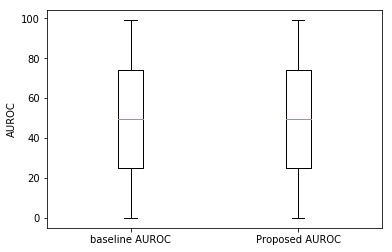

In [31]:
data=range(100)
import matplotlib.pyplot as plt
plt.boxplot([baseline_auroc,proposed_auroc])
plt.xticks([1, 2], ["baseline CNN","Proposed CNN"])
plt.ylabel("AUROC")

In [37]:
import numpy as np
from scipy import stats

a=np.load("baseline_auroc.npy")
b=np.load("proposed_auroc.npy")
def t_test(list1,list2):

  N = len(list1)
  a=np.array(list1)
  b=np.array(list2)
  var_a = a.var(ddof=1)
  var_b = b.var(ddof=1)
  s = np.sqrt((var_a + var_b)/2)
  t = (a.mean() - b.mean())/(s*np.sqrt(2/N))
  df = 2*N - 2
  return p


#t_test(a,b)
from scipy import stats
stats.ttest_ind(a,b)

Ttest_indResult(statistic=-3.7072911056641455, pvalue=0.00033245168706704875)